#### ML Analysis #3 - SVM
Chesta Dewangan

SVM helps in reducing overfitting and works well with binary classification.

Why SVM?
- Logistic Regression is linar and interpretable and Gradient Boosting is powerful but can overfit.
- SVM adds a margin-based classifier which balances between GBM'S power and Logistic Regression's simplicty.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, roc_auc_score, ConfusionMatrixDisplay, classification_report)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [2]:
# Load the (preprocessed) data
df = pd.read_csv("ckd_preprocessed.csv")

Preprocessing Setup

In [3]:
X = df.drop('classification', axis=1)
y = df['classification']

le = LabelEncoder()
y = le.fit_transform(y)

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

Data Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

SVM Pipeline

In [5]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])

Train & Predict

In [6]:
svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)
y_proba = svm_pipeline.predict_proba(X_test)[:, 1]

Accuracy: 0.99
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.97      1.00      0.99        37

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

ROC AUC Score: 1.0


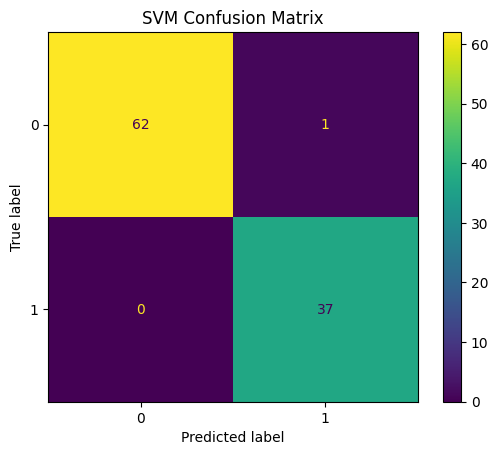

In [7]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("SVM Confusion Matrix")
plt.show()

Despite achieving perfect performance metrics (accuracy, precision, recall, and AUC = 1.0), these results should be interpreted cautiously. The dataset we have is relatively small, and a significant portion of the data had missing values that were imputed in the EDA section. This, combined with potential overfitting, leads to artificially high performance.

That's why we will now understand what factors contribute most to the model’s decisions instead of just looking at accuracy and other metrics.

In [8]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 0.01, 0.001],
    'classifier__kernel': ['rbf']
}

grid_svm = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_svm.fit(X_train, y_train)

print("Best parameters:", grid_svm.best_params_)
print("Best ROC AUC on validation:", grid_svm.best_score_)

best_svm_model = grid_svm.best_estimator_
y_pred = best_svm_model.predict(X_test)
y_proba = best_svm_model.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best ROC AUC on validation: 1.0


SHAP-like Interpretability for SVM
SHAP doesn't support SVM so I tried Scikit-learn based permutation importance.

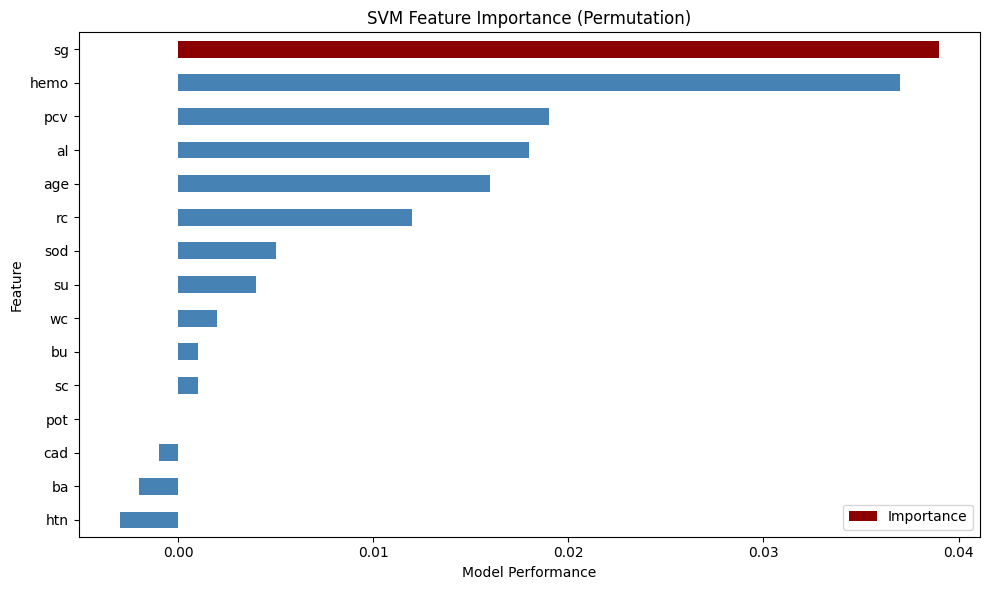

In [9]:
result = permutation_importance(best_svm_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

colors = ['darkred'] + ['steelblue'] * (len(perm_df.head(15)) - 1)

perm_df.head(15).plot(
    x='Feature',
    y='Importance',
    kind='barh',
    color=colors,
    figsize=(10, 6),
    title="SVM Feature Importance (Permutation)"
)

plt.gca().invert_yaxis()
plt.xlabel("Model Performance")
plt.tight_layout()
plt.show()

The chart shows which features are the most important for SVM's predictions. This is done by shuffling one feature at a time and checking how much accuracy drops, which means bigger drops lead to more critical features. 

From the chart, we can see that rbc (Red Blood Cells) is the most crucial feature, which means when it was shuffled, the model performed much worse, indicating that CKD risk is higher. In particular, if we look at the x-axis, the bar for rbc is around 0.030 which means the AUC or accuracy drops by about 0.030 on average.

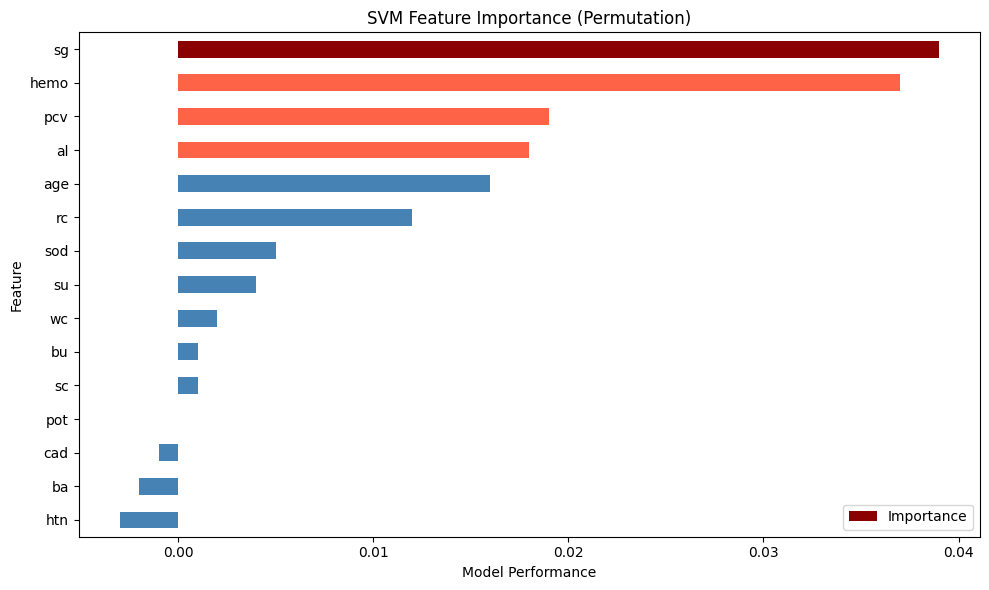

In [10]:
top_n = 15
top_features = perm_df.head(top_n)

colors = (
    ['darkred'] +                     # most important one
    ['tomato'] * 3 +              # next 3 important ones
    ['steelblue'] * (top_n - 4)       # rest of the features
)

top_features.plot(
    x='Feature',
    y='Importance',
    kind='barh',
    color=colors,
    figsize=(10, 6),
    title="SVM Feature Importance (Permutation)"
)

plt.gca().invert_yaxis()
plt.xlabel("Model Performance")
plt.tight_layout()
plt.show()

The above chart is similar to the previous one, this one just highlights the next 3 important features after RBC in a lighter red color, which impacts the accuracy of the model.